# I - Algorithme de Clustering : K-means

Importons les packages nécessaires :

In [1]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans

### 1) Présentation de la base de données des iris

Le chargement de la **base de données des iris**$^{[5]}$ sera fait à l'aide de la bibliothèque Scikit-learn sur l'exemple de sa documentation en ligne$^{[6]}$.

In [2]:
iris = datasets.load_iris()

#### Présentation des sections majeures des données

La base de données prend la forme d'une matrice de dimension $150 \times 4$. On notera $m$ son nombre de lignes et $n$ son nombre de colonnes. Chaque iris (50 exemples d'iris parmi trois classes) est une donnée qu'on notera $x_{i}$ (i $\in \{0,...,149\}$) que la matrice stocke sous forme de ligne, avec $x_{i} \in \mathbb{R}_{+}^{4}$. La matrice de données est accessible par la commande **iris.data**.

Scikit-learn nous donne également accès aux classes des données. En effet, la commande **iris.target** retourne le vecteur de dimension 150 contenant les labels des données (label = 0, 1 ou 2). On notera $y_{i} \in \{0,1,2\}$ le label associé à la donnée $x_{i}$. On peut voir que le label 0 encode la classe 'setosa', le label 1 la classe 'versicolor' et le label 2 la classe 'virginica' :

In [3]:
Mat,Label,Colonnes , Class_names = iris.data, iris.target, iris.feature_names, iris.target_names
print('La matrice de données est de dimension',np.shape(Mat))
print('Le vecteur de labels est de dimension',np.shape(Label))
print("Nom des colonnes :", Colonnes)
print("Nom des classes :",Class_names)

La matrice de données est de dimension (150, 4)
Le vecteur de labels est de dimension (150,)
Nom des colonnes : ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Nom des classes : ['setosa' 'versicolor' 'virginica']


Imprimons les entrées du premier iris de la base (de classe setosa) :

In [4]:
print('Iris de type', Class_names[Label[0]])
print('Label = ', Label[0])
for i in range(4):
    print(Colonnes[i], Mat[0,i])

Iris de type setosa
Label =  0
sepal length (cm) 5.1
sepal width (cm) 3.5
petal length (cm) 1.4
petal width (cm) 0.2


#### Visualisation des données en 2 dimensions (sur la base des pétales puis des sépales)

Visualisons les données sur la base des données des pétales (deux dernières colonnes de la matrice) :

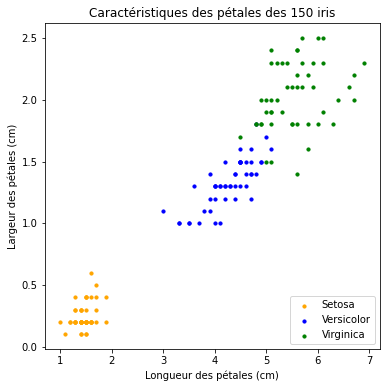

In [5]:
plt.figure(figsize=(6,6))
plt.title("Caractéristiques des pétales des 150 iris")
plt.scatter(Mat[:50,2],Mat[:50,3],s=10,c='orange',label='Setosa')
plt.scatter(Mat[50:100,2],Mat[50:100,3],s=10,c='blue',label='Versicolor')
plt.scatter(Mat[100:,2],Mat[100:,3],s=10,c='green',label='Virginica')
plt.xlabel("Longueur des pétales (cm)")
plt.ylabel("Largeur des pétales (cm)")
plt.legend(loc='lower right')
plt.show()

De même, visualisons les données sur la base des caractéristiques des sépales des iris (deux premières colonnes de la matrice) :

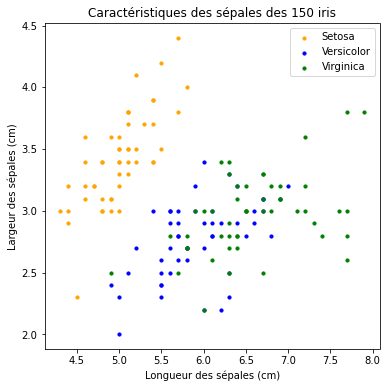

In [6]:
plt.figure(figsize=(6,6))
plt.title("Caractéristiques des sépales des 150 iris")
plt.scatter(Mat[:50,0],Mat[:50,1],s=10,c='orange',label='Setosa')
plt.scatter(Mat[50:100,0],Mat[50:100,1],s=10,c='blue',label='Versicolor')
plt.scatter(Mat[100:,0],Mat[100:,1],s=10,c='green',label='Virginica')
plt.xlabel("Longueur des sépales (cm)")
plt.ylabel("Largeur des sépales (cm)")
plt.legend()
plt.show()

#### Visualisation en 2D par analyse en composantes principales (ACP)

Nous utilisons ci-dessous l'outil d'ACP de Scikit-learn afin de représenter l'ensemble des données (qui sont de dimension 4) en deux dimensions. La documentation de cet outil est disponible en ligne$^{[7]}$ : il réalise la réduction de dimension par décomposition en valeurs singulières (SVD). De plus, les données sont centrées mais pas normalisées pour chaque caractéristique avant que la SVD ne soit appliquée.

In [7]:
pca = PCA(n_components=2)
Mat_PCA=pca.fit_transform(Mat)
print('La matrice obtenue par ACP est de dimension' ,np.shape(Mat_PCA))

La matrice obtenue par ACP est de dimension (150, 2)


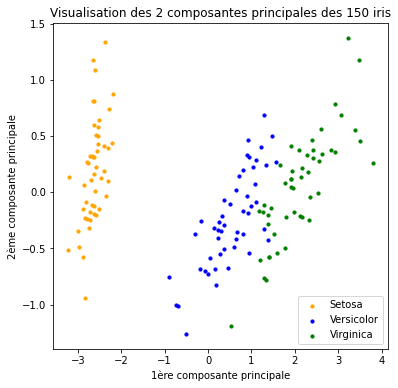

In [8]:
plt.figure(figsize=(6,6))
plt.title("Visualisation des 2 composantes principales des 150 iris")
plt.scatter(Mat_PCA[:50,0],Mat_PCA[:50,1],s=10,c='orange',label='Setosa')
plt.scatter(Mat_PCA[50:100,0],Mat_PCA[50:100,1],s=10,c='blue',label='Versicolor')
plt.scatter(Mat_PCA[100:,0],Mat_PCA[100:,1],s=10,c='green',label='Virginica')
plt.xlabel("1ère composante principale")
plt.ylabel("2ème composante principale")
plt.legend()
plt.show()

**Remarque sur les labels et le nombre de clusters $K$ :**

Dans la suite, lors de la phase d'apprentissage de notre algorithme K-means, nous n'allons plus utiliser notre connaissance des labels $y_{i}$ des iris. Notre but sera d'identifier $K=3$ clusters (via une fonction d'assignation $\rho$, comme détaillée en introduction) sur la base des seuls $(x_{i})_{0\leq i \leq 149}$.

Le fait de spécifier que $K=3$ est dû ici à notre connaissance de la base de données : nous savons qu'il y a trois types d'iris différents dans notre échantillon que nous souhaitons identifier. De manière générale, dans la classification non supervisée, le choix du nombre de clusters peut être motivé par les besoins de l'utilisateur (par exemple, besoin de diviser sa base de données de consommateurs en $x$ groupes) ou encore peut faire l'objet d'une analyse supplémentaire permettant de trouver un modèle qui effectue le meilleur compromis biais-variance dans son adaptation aux données. Nous explorerons davantage la question du choix du modèle dans notre deuxième partie, dédiée au co-clustering. 

### 2) Algorithme K-means

Le premier algorithme que nous mettrons en oeuvre est un algorithme itératif qui associera à chaque donnée $x_{i}$ un label associé à un cluster k $\in \{0,1,2\}$ : c'est un procédé de partitionnement. Le centroïde (moyenne) de chaque cluster $k$ sera noté $C_{k}$. 

L'objectif des itérations de l'algorithme est de minimiser une fonction dit "objectif" qui permettra de quantifier la qualité d'un partitionnement $P$. Nous nous sommes basés sur le chapitre 9 de l'ouvrage de L. Elden, *Matrix Methods in Data Mining and Pattern Recognition*$^{[2]}$ afin de définir cette fonction, que l'on notera $Q$ :

$$Q(P)=\sum_{k=0}^{K-1} \sum_{i: \rho(i)=k} ||x_{i}-C_{k}||_{2}^{2}$$
    
L'algorithme cherchera à converger vers le partitionnement optimal soit $min_{P}Q(P)$.

#### Etapes de l'algorithme

* **Initialisation des centroïdes** : 

On tire aléatoirement $K$ données au sein de notre échantillon comme centroïdes (ou centres des clusters) initiaux. 

Dans notre cas, on pourra par exemple tirer $K=3$ entiers selon la distribution uniforme discrète parmi les 150 indices $i \in \{0,...,149\}$ des lignes de notre matrice de données. Cela nous donnera les indices des 3 lignes correspondant aux iris utilisés comme centroïdes initiaux, qu'on notera $C_{0}^{(0)},C_{1}^{(0)}\text{ et }C_{2}^{(0)}$ (l'exposant indique qu'il s'agit de l'itération n° 0). 

* **Phase itérative (à l'étape $t$)** : 

 * 1e sous-étape itérative : associer chaque iris au label du centroïde le plus proche
 
 On attribue à chaque donnée $x_{i}$, le label $k \in \{0,1,2\}$ associé au centroïde le plus proche. Pour chaque donnée $x_{i}$ (avec $i \in \{0,...,149\}$), on utilisera la norme euclidienne afin de comparer sa distance à chacun des centroïdes. Rappelons qu'on notera $\rho(i)=k$ le fait que l'on attribue le label $k$ à la donnée  $x_{i}$. Ainsi, $\forall i \in \{0,...,149\}$ :
 
$$\rho^{(t)}(i)=\mathop{\textrm{argmin}}_{k\in\{0,1,2\}} ||x_{i}-C_{k}^{(t)}||_{2}^{2}$$
 
 * 2e sous-étape itérative : 
 
On recalcule les coordonnées de chaque centroïde en faisant la moyenne des coordonnées des données qui lui ont été associées à la sous-étape 1. Ainsi, avec $k \in \{0,1,2\}$ :

$$C_{k}^{(t)}= \frac{1}{\#\{i: \rho(i)=k\}} \sum_{i: \rho(i)=k} x_{i}$$

On peut alors réévaluer la fonction objectif au temps $t$. Il s'agit de calculer : $Q(P^{(t)})$.

* **Arrêt après convergence** :

L'algorithme K-means consiste à itérer sur les deux étapes décrites ci-dessus jusqu'à "convergence" (atteinte du critère d'arrêt). Ce critère d'arrêt mettra fin à l'algorithme dans deux cas de figure : 
  * si le nombre d'itérations dépasse un nombre maximal prédéfini d'itérations (cela permet d'éviter les boucles infinies mais on considèrera que l'algorithme n'a pas convergé)
  * si chaque nouvelle itération ne fait plus diminuer la fonction objectif de plus d'un certain seuil, noté $\epsilon$ (on considèrera que l'algorithme a convergé) :
 
$$|Q(P^{(t)})-Q(P^{(t-1)})|\leq \epsilon$$

### 3) Mise en oeuvre en Python

#### Initialisation aléatoire des centroïdes au sein des données

In [9]:
K=3 # nombre de centroïdes
n=4 # nombre de colonnes de la matrice
m=150 # nombre de lignes de la matrice

In [18]:
def centroids_init(K, Mat):
    Index=np.random.randint(0, m, size=K)
    centroids=Mat[Index,:]
    return centroids

In [19]:
centroids=centroids_init(K, Mat)
print("Les centroïdes initiaux sont stockés sous la forme d'une matrice Kxn : \n",centroids)

Les centroïdes initiaux sont stockés sous la forme d'une matrice Kxn : 
 [[6.9 3.1 5.1 2.3]
 [4.9 2.4 3.3 1. ]
 [7.9 3.8 6.4 2. ]]


Nous souhaitons visualiser par ACP ce choix aléatoire de centroïdes initiaux. Pour cela, il faut appliquer l'ACP aux données et aux centroïdes simultanément. Pour ce faire, nous définissons une matrice augmentée **Mat_2** qui concatène en ligne les données et les centroïdes. 

In [20]:
Mat_2=np.zeros((m+K,n))
Mat_2[:m,:]=Mat
Mat_2[m:,:]=centroids
Mat_PCA_2=pca.fit_transform(Mat_2)

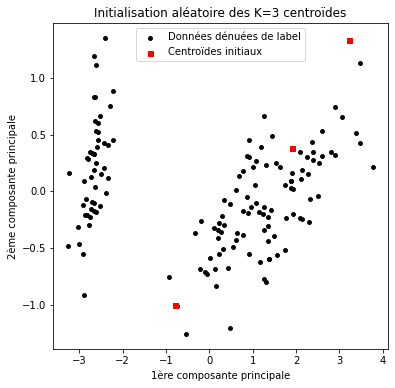

In [21]:
plt.figure(figsize=(6,6))
plt.title("Initialisation aléatoire des K=3 centroïdes")
plt.scatter(Mat_PCA_2[:m,0],Mat_PCA_2[:m,1],s=15,c='black',label='Données dénuées de label')
plt.scatter(Mat_PCA_2[m:,0],Mat_PCA_2[m:,1],marker='s',s=25,c='red',label='Centroïdes initiaux')
plt.xlabel("1ère composante principale")
plt.ylabel("2ème composante principale")
plt.legend(loc='upper center')
plt.show()

#### 1ère étape itérative : attribuer à chaque iris le label du centroïde le plus proche

In [22]:
def find_closest_centroid(Mat,centroids):
    Idx_closest_centroid=[]
    
    #boucle dans les données
    for j in range(m): 
        d=[]
        
        # boucle dans les centroides
        for i in range(K): 
            d.append(np.linalg.norm(Mat[j,:]-centroids[i,:]))  # utilisation de la norme euclidienne  
            
        # attribuons l'index du centroide le plus proche à l'exemple j considéré :
        idx=np.argmin(d) 
        Idx_closest_centroid.append(idx)
        
    return np.array(Idx_closest_centroid)

Après une itération de la première étape de l'algorithme, visualisons la première attribution de chaque point à un centroïde, en utilisant une couleur propre à chaque centroïde.

In [23]:
Idx=find_closest_centroid(Mat,centroids)

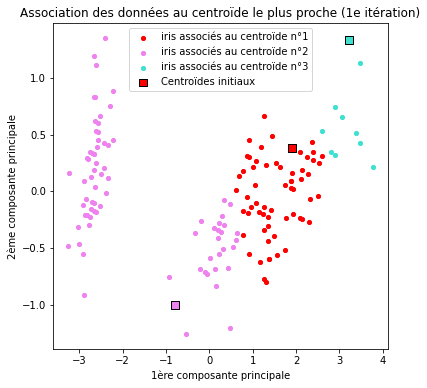

In [24]:
plt.figure(figsize=(6,6))
plt.title("Association des données au centroïde le plus proche (1e itération)")
centroid_colors=['red','violet','turquoise'] 
for i in range(K): # traçons chaque point avec la couleur du centroide qui leur est associé
    plt.scatter(Mat_PCA_2[:150,0][Idx==i],Mat_PCA_2[:150,1][Idx==i],s=17,c=centroid_colors[i],label="iris associés au centroïde n°{}".format(i+1)) 
plt.scatter(Mat_PCA_2[150:,0],Mat_PCA_2[150:,1],c=centroid_colors,edgecolors= "black",marker='s',s=63,label='Centroïdes initiaux')
plt.xlabel("1ère composante principale")
plt.ylabel("2ème composante principale")
plt.legend(loc='upper center')
plt.show()

#### 2ème étape itérative : mise à jour des coordonnées des centroïdes

On recalcule les coordonnées de chaque centroïde (en faisant la moyenne des coordonnées des points qui lui ont été associés à l'étape 1).

In [25]:
def centroids_means(Mat,Idx_closest_centroid):
    Centroids=np.zeros((K,n))
    q_list=[]
    for i in range(K):
        
        Idx=(Idx_closest_centroid==i) # index des points qui ont été attribués au centroide i 
        
        # si j'ai au moins un point d'assigné au centroide i, je recalcule ses coordonnées
        if any(Idx) == True: 
        
            Points=Mat[Idx] # on ne garde que ces points parmi les données
            new_coor=np.mean(Points,axis=0)  # nouvelles coordonnées du centroide (moyenne par colonne)
            Centroids[i,:]=new_coor
        
            # calcul du "coût" q_i du cluster i considéré
            # on prend le carré de la norme de Frobenius pour calculer q_i
            q=(np.linalg.norm(Points - Centroids[i,:]))**2 
            q_list.append(q)
        
        # si aucun point n'a été assigné au centroide i, on ne bouge pas ce  
        # centroide et on n'ajoute rien au cout (car la somme est vide)
    Q_total=sum(q_list)
    
    return Centroids, Q_total

In [26]:
Centroids,Q_total=centroids_means(Mat,Idx)

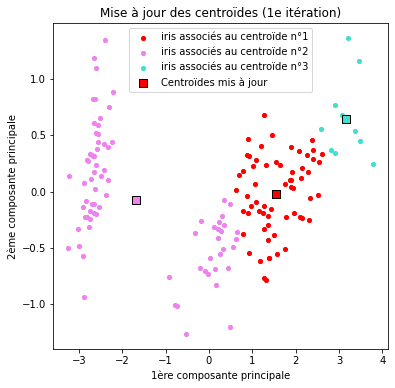

In [28]:
Mat_2=np.zeros((m+K,n))
Mat_2[:m,:]=Mat
Mat_2[m:,:]=Centroids
Mat_PCA_2=pca.fit_transform(Mat_2)

plt.figure(figsize=(6,6))
plt.title("Mise à jour des centroïdes (1e itération)")
centroid_colors=['red','violet','turquoise'] 
for i in range(K): # traçons chaque point avec la couleur du centroide qui leur est associé
    plt.scatter(Mat_PCA_2[:150,0][Idx==i],Mat_PCA_2[:150,1][Idx==i],s=17,c=centroid_colors[i],label="iris associés au centroïde n°{}".format(i+1)) 
plt.scatter(Mat_PCA_2[150:,0],Mat_PCA_2[150:,1],c=centroid_colors,edgecolors= "black",marker='s',s=63,label='Centroïdes mis à jour')
plt.xlabel("1ère composante principale")
plt.ylabel("2ème composante principale")
plt.legend(loc='upper center')
plt.show()

In [31]:
################################################
# ajouté
seuil=0.0001
n_iter=100
# Q_list liste les évaluations de la fonction objectif après chaque itération
Q_list=[math.inf] # on stocke artificiellement un 1er "coût" de valeur infinie
critere=True # pour rentrer dans la boucle while
it=0 # compteur du nombre d'itérations 
    
while (critere==True):
    Idx=find_closest_centroid(Mat,Centroids)
    Centroids,Q=centroids_means(Mat,Idx)
    Q_list.append(Q)
    diff=abs(Q_list[-2]-Q_list[-1]) # différence en valeur absolue des deux derniers couts
    it=it+1
        
    if (diff <= seuil) :
        conv=True # conv est un booléen qui indique si on a convergé 
        critere=False # permet de sortir de la boucle while 
        
    if (it>=n_iter):
        conv=False
        critere=False
################################################

In [35]:
################################################
Q_list[-1]
################################################

78.851441426146

#### Convergence de l'algorithme et critère d'arrêt

Notre fonction centroids_means calcule à la fois les nouvelles coordonnées des centroïdes mais aussi le coût du partitionnement $P$ obtenu à la fin d'une itération des étapes 1 et 2 : il s'agit d'évaluer notre fonction objectif $Q$. Voyons le coût obtenu après une itération des étapes 1 et 2 : 

In [18]:
Q_total

100.59224999999998

#### Intégrons toutes nos fonctions précédentes en une unique fonction K-means (avec critère d'arrêt).

In [29]:
def k_means(Mat,K=3,seuil=0.0001,n_iter=100):

    Centroids=centroids_init(K, Mat) # Initialisation des centroïdes
    
    # Q_list liste les évaluations de la fonction objectif après chaque itération
    Q_list=[math.inf] # on stocke artificiellement un 1er "coût" de valeur infinie
    critere=True # pour rentrer dans la boucle while
    it=0 # compteur du nombre d'itérations 
    
    while (critere==True):
        Idx=find_closest_centroid(Mat,Centroids)
        Centroids,Q=centroids_means(Mat,Idx)
        Q_list.append(Q)
        diff=abs(Q_list[-2]-Q_list[-1]) # différence en valeur absolue des deux derniers couts
        it=it+1
        
        if (diff <= seuil) :
            conv=True # conv est un booléen qui indique si on a convergé 
            critere=False # permet de sortir de la boucle while 
        
        if (it>=n_iter):
            conv=False
            critere=False
            
    return Idx, Centroids, Q_list, conv, it

In [20]:
Idx_final, Centroids_final, Q_list_final,conv,it =k_means(Mat,K=3,seuil=0.0001,n_iter=100)

### 4) Analyse des résultats

#### Quelques fonctions graphiques utiles 

Définissons une fonction permettant de visualiser en 2D par ACP les clusters finaux obtenus.

In [32]:
def graph_results(Mat,Idx,Centroids): 
    # on définit une matrice augmentée 
    Mat_2=np.zeros((m+K,n))
    Mat_2[:m,:]=Mat
    Mat_2[m:,:]=Centroids
    # on applique l'ACP à cette matrice 
    pca = PCA(n_components=2)
    Mat_PCA_2=pca.fit_transform(Mat_2)
    # on trace le graphique 
    plt.figure(figsize=(6,6))
    plt.title("ACP des centroïdes et iris associés après arrêt de l'algorithme")
    centroid_colors=['red','violet','turquoise']
    for i in range(K):
        plt.scatter(Mat_PCA_2[:m,0][Idx==i],Mat_PCA_2[:m,1][Idx==i],s=17,c=centroid_colors[i],label="iris associés au centroïde n°{}".format(i+1)) 
    plt.scatter(Mat_PCA_2[m:,0],Mat_PCA_2[m:,1],c=centroid_colors,edgecolors= "black",marker='s',s=63,label='Centroïdes')
    plt.xlabel("1ère composante principale")
    plt.ylabel("2ème composante principale")
    plt.legend(loc='upper center')
    plt.show()

In [34]:
################################################
# ajouté
# graph_results(Mat,Idx,Centroids)
################################################

Définissons également une fonction permettant de visualiser l'évolution de la fonction objectif (coût du partitionnement) en fonction du nombre d'itérations (des étapes 1 et 2) :

In [22]:
def cout_par_iteration(Q_list):
    X=np.arange(1,len(Q_list)+1,1) # abscisses du graphique
    plt.figure(figsize=(5,5))
    plt.title("Coût du partitionnement en fonction du nombre d'itération")
    plt.plot(X,Q_list)
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Coût")
    plt.show()

#### 4.1 ) Coûts de partitionnement finaux

#### Coûts finaux obtenus pour $N=10$ initialisations différentes et leur fréquence

L'algorithme K-means étant susceptible de converger vers des minima locaux en fonction de son initialisation, il est recommandé de l'exécuter plusieurs fois afin de sélectionner la meilleure solution (celle qui aura minimisé le plus la fonction objectif). Après consultation avec Mme Matias et analyse empirique, il est apparu que $N=10$ initialisations était suffisant.

In [25]:
N=10
Final_Idx_list=[]
Final_centroids_list=[]
All_costs_list=[]
Last_cost_list=[]
Conv_list=[]

for i in range(N):
    Idx_final, Centroids_final, Q_list,conv,it = k_means(Mat,K=3,seuil=0.0001,n_iter=100)
    Final_Idx_list.append(Idx_final)
    Final_centroids_list.append(Centroids_final)
    All_costs_list.append(Q_list)
    Last_cost_list.append(Q_list[-1]) # on ne stocke que la dernière valeur de coût
    Conv_list.append(conv)

In [28]:
Last_cost_rounded=np.round(Last_cost_list,3) # on ne garde que des valeurs arrondies 
Val,Freq=np.unique(Last_cost_rounded, return_counts = True) # on peut aussi utiliser Counter pour ce compte
print('Liste des coûts finaux atteints (arrondis à 3 décimales) et leur fréquence pour N=10 initialisations :')
for i in range(len(Freq)):
    print(f'Coût: {Val[i]}, obtenu avec fréquence : {Freq[i]}')

Liste des coûts finaux atteints (arrondis à 3 décimales) et leur fréquence pour N=10 initialisations :
Coût: 78.851, obtenu avec fréquence : 4
Coût: 78.856, obtenu avec fréquence : 3
Coût: 142.754, obtenu avec fréquence : 2
Coût: 145.453, obtenu avec fréquence : 1


Le minimum global semble atteint pour les initialisations qui ont obtenu un coût final de partitionnement de 78,851. On observe que la première itération (notamment) de notre algorithme a convergé vers ce minimum global et que la seconde a convergé vers le minimum de coût final 78,856.

In [29]:
print("Cout de la première itération :",Last_cost_rounded[0])
print("Cout de la seconde itération :",Last_cost_rounded[1])

Cout de la première itération : 78.851
Cout de la seconde itération : 78.856


In [30]:
print("Nombre d'iris classifiés différemment par ces deux itérations :", np.sum(Final_Idx_list[0]!=Final_Idx_list[1]))

Nombre d'iris classifiés différemment par ces deux itérations : 1


On remarque qu'un partitionnement ayant un coût final de 78,851 diffère d'un partitionnement ayant un coût final de 78,856 en classifiant différemment un iris exactement. Il est donc important de considérer ces partitionnements comme distincts malgré la proximité de leur coût final. 

Visualisons graphiquement les résultats associés à cette réalisation optimale de l'algorithme. 

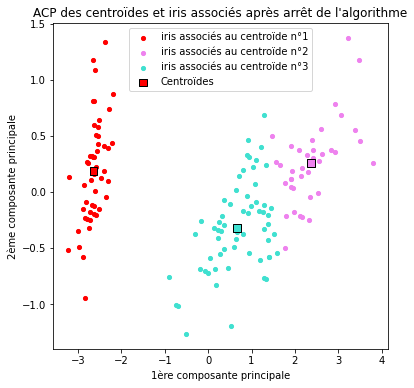

In [31]:
graph_results(Mat,Final_Idx_list[0],Final_centroids_list[0])

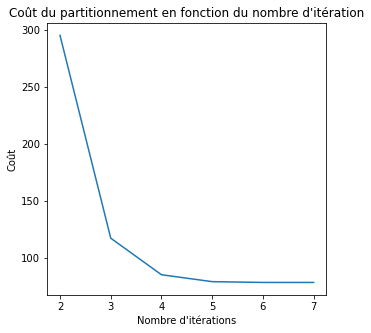

In [32]:
cout_par_iteration(All_costs_list[0])

#### 4.2) Précision de l'algorithme

**Pourcentage de classification juste ("accuracy")**

Une première manière de quantifier la qualité de notre classification est de comparer les classes prédites par l'algorithme (lors d'un partitionnement optimal obtenu pour $N$ initialisations) avec les vrais labels des données afin de calculer le pourcentage de précision. 

Ici, ce qui importera ne sera pas d'avoir le "bon" numéro de label pour chaque donnée mais de voir que les données d'un même type ont été groupées ensemble (via un même label). Cela est dû au *label switching*, phénomène connu de la classification non supervisée : il est possible que l'algorithme ait correctement identifié les groupes mais les ait seulement numéroté d'une manière différente de celle des données originelles. Quand on compare des labels estimés et réels, il faut donc travailler à permutation près. 

L'accès aux vrais labels est simple car nos données sont ordonnées : les 50 premières lignes de la matrice regroupent les $x_{i}$ d'un même type et ainsi de suite pour les 50 lignes suivantes puis pour les 50 dernières. Ainsi, un partitionnement idéal attribuerait un même label aux 50 premières données, puis un même autre label aux 50 suivantes, et enfin le dernier label aux 50 dernières. 

In [33]:
Label_approx=Final_Idx_list[0]
print("Labels associés au 1er type d'iris : ") 
print(Label_approx[0:50])
print("Labels associés au 2e type d'iris : ")
print(Label_approx[50:100])
print("Labels associés au 3e type d'iris : ")
print(Label_approx[100:150])

Labels associés au 1er type d'iris : 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels associés au 2e type d'iris : 
[2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
Labels associés au 3e type d'iris : 
[1 2 1 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1 1 1 1 2 1 1 1
 1 2 1 1 1 2 1 1 1 2 1 1 2]


On remarque que :
* le partitionnement a parfaitement regroupé les iris de premier type ensemble.
* 2 iris de type 3 ont été regroupés à tort avec les iris de type 2.
* 14 iris de type 2 ont été regroupés à tort avec les iris de type 3.

Au total, 16 iris ont été associés au mauvais cluster sur un total de 150. On peut donc estimer que la **précision de notre algorithme est de $\frac{150-16}{150} \approx 89\%$**.

**Matrice de confusion**

L'analyse que nous venons de faire naïvement sur la base des labels estimés est usuellement menée sur la base d'une matrice de confusion. Une telle matrice (de taille $K \times K$) est un outil d'analyse des résultats de classification qui donne en position $(k,l)$ le nombre d’individus classés $l$ par l’estimateur et dont le vrai groupe est $k$. Si notre estimateur est bon, cette matrice devrait avoir une seule grande entrée par ligne et par colonne (car à permutation près, cette matrice est diagonale dans le cas où les bonnes classes ont été estimées). Nous avons codé cette matrice ci-dessous :

In [34]:
Confusion=np.zeros((3,3),dtype=int)

In [35]:
for k in range(50): # on sait que les 50 premiers iris ont pour vrai label 0 
    for l in range(3):
        if Label_approx[k]==l:
            Confusion[0,l]+=1
            
for k in range(50,100): # on sait que les 50 suivants ont pour vrai label 1
    for l in range(3):
        if Label_approx[k]==l:
            Confusion[1,l]+=1
            
for k in range(100,150): # on sait que les 50 derniers ont pour vrai label 2
    for l in range(3):
        if Label_approx[k]==l:
            Confusion[2,l]+=1

In [36]:
print(Confusion)

[[50  0  0]
 [ 0  2 48]
 [ 0 36 14]]


Vérifions que nous avons bien obtenu la même matrice que celle retournée par le module "contingency_matrix" de Scikit-learn :

In [37]:
Confusion_2=contingency_matrix(Label, Label_approx)
print(Confusion_2)

[[50  0  0]
 [ 0  2 48]
 [ 0 36 14]]


#### 4.3) Mesures de similarité entre deux partitions 

Une autre manière d'évaluer la qualité d'une classification passe par le recours à une mesure de similarité entre deux partitions (à permutation près). Nous allons donc utiliser deux mesures de ce type.

* *Normalized mutual information* (NMI) 

Une approche largement utilisée dans le domaine de l'apprentissage statistique consiste à calculer l'information mutuelle normalisée ou *Normalized mutual information*$^{[8]}$ (abrégée en "NMI") entre le vecteur de labels estimés et celui de labels réels.

Rappelons que l'information mutuelle entre deux variables $X$ et $Y$ permet de quantifier l'information que la réalisation d'une variable apporte sur l'autre. On parle aussi de degré de dépendance mutuelle. Si les variables sont indépendantes, l'information mutuelle est nulle. Plus la dépendance augmente et plus la valeur est grande. En notant $p_{(X,Y)}(x,y)$ la densité jointe du couple $(X,Y)$, $P_{X}(x)$ et $P_{Y}(y)$ les densités marginales et $H(.)$ l'entropie des variables, on peut calculer l'information mutuelle $I(X;Y)$ (qui est symétrique) et l'information mutuelle **normalisée** $NMI(Y;X)\in [0,1]$ comme suit pour des variables discrètes : 

$$I(Y;X)=\sum_{y} \sum_{x} p_{(X,Y)}(x,y) \log \left( \frac{p_{(X,Y)}(x,y)}{P_{X}(x)P_{Y}(y)} \right)\text{  et  }NMI(Y;X)=\frac{2 \times I(Y;X)}{H(Y)+H(X)}$$

La documentation de Scikit-learn$^{[8]}$ indique la commande permettant de calculer l'information mutuelle normalisée entre deux vecteurs. Dans notre cas, on obtient un degré d'information mutuelle normalisée d'environ 0,76 :

In [38]:
print("Valeur de NMI obtenue :", normalized_mutual_info_score(Label, Label_approx))

Valeur de NMI obtenue : 0.7581756800057784


* *Adjusted Rand Index* (ARI)

Une autre mesure de similarité entre deux partitions est l'indice de Rand ajusté ou *Adjusted Rand Index* (abrégé en "ARI"). Cette mesure a pour but de quantifier la proportion de paires (au sein des données) ayant été classifiées de la même manière par les deux partitions par rapport au nombre total de paires possibles. 

Dans sa version ajustée, ses valeurs sont comprises dans l'intervalle $[-1,1]$. Une valeur proche de 0 traduit une situation où les deux partitions ont été effectuées de manière aléatoire et indépendante. Une valeur proche de 1 traduit un clustering identique (à permutation près). Comme la NMI, l'ARI est symétrique et a été mise en oeuvre au sein de Scikit-learn comme le détaille sa documentation$^{[9]}$. Dans le cadre de cette nouvelle métrique, nous obtenons une valeur d'environ 0,73 :

In [39]:
print("Valeur de ARI obtenue :", adjusted_rand_score(Label, Label_approx))

Valeur de ARI obtenue : 0.7302382722834697


#### 4.4) Visualisation des données mal classifiées

Voyons graphiquement où se situent les iris mal classifiés.

In [40]:
L2=[52,77]  # indices des iris de 2e type associé au 3ème par erreur

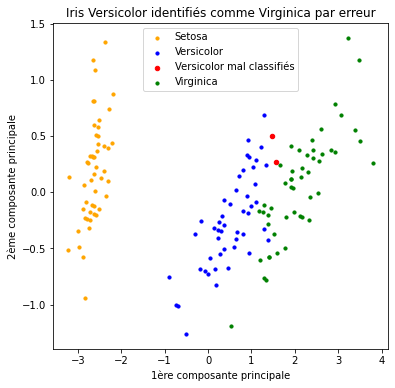

In [41]:
plt.figure(figsize=(6,6))
plt.title("Iris Versicolor identifiés comme Virginica par erreur")
plt.scatter(Mat_PCA[:50,0],Mat_PCA[:50,1],s=10,c='orange',label='Setosa')
plt.scatter(Mat_PCA[50:100,0],Mat_PCA[50:100,1],s=10,c='blue',label='Versicolor')
plt.scatter(Mat_PCA[L2,0],Mat_PCA[L2,1],s=20,c='red',label='Versicolor mal classifiés')
plt.scatter(Mat_PCA[100:,0],Mat_PCA[100:,1],s=10,c='green',label='Virginica')
plt.xlabel("1ère composante principale")
plt.ylabel("2ème composante principale")
plt.legend(loc='upper center')
plt.show()

In [42]:
# indices des iris de 2e type associé au 3ème par erreur
L3=[101, 106, 113, 114, 119, 121, 123, 126, 127, 133, 138, 142, 146, 149]

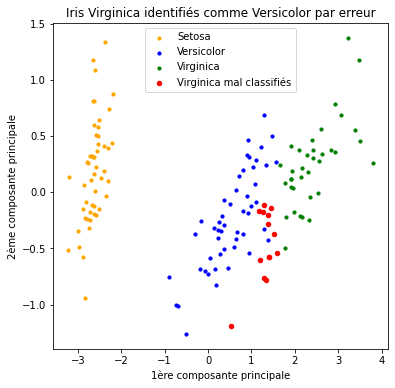

In [43]:
plt.figure(figsize=(6,6))
plt.title("Iris Virginica identifiés comme Versicolor par erreur")
plt.scatter(Mat_PCA[:50,0],Mat_PCA[:50,1],s=10,c='orange',label='Setosa')
plt.scatter(Mat_PCA[50:100,0],Mat_PCA[50:100,1],s=10,c='blue',label='Versicolor')
plt.scatter(Mat_PCA[100:,0],Mat_PCA[100:,1],s=10,c='green',label='Virginica')
plt.scatter(Mat_PCA[L3,0],Mat_PCA[L3,1],s=20,c='red',label='Virginica mal classifiés')
plt.xlabel("1ère composante principale")
plt.ylabel("2ème composante principale")
plt.legend(loc='upper center')
plt.show()

Sans grande surprise, les iris mal classifiés sont ceux qui se situent au niveau de l'intersection des clusters de type Virginica et Versicolor qui se chevauchent légèrement. Le type Setosa étant bien séparé des deux autres, aucun de ses iris n'ont été mal identifiés.

### 5) Comparaison de nos résultats avec ceux du module K-means de Scikit-learn

La librairie Scikit-learn disposant d'un module K-means, nous avons souhaité conclure cette partie en comparant les résultats obtenus par ce dernier aux nôtres. 

La documentation$^{[10]}$ précise que par défaut le module utilise - comme nous - $N=10$ initialisations. Les commandes **kmeans.labels_** et **kmeans.cluster_centers_** permettent d'accéder aux clusters et aux labels établis par le module. Cela nous permet de comparer la matrice de confusion que nous avons obtenue plus haut à celle obtenue à l'aide de ce module.

In [44]:
K=3
kmeans = KMeans(n_clusters=K, init='k-means++').fit(Mat)

print("Labels associés par le module k-means au 1er type d'iris : ") 
print(kmeans.labels_[0:50])
print("Labels associés par le module k-means au 2e type d'iris : ")
print(kmeans.labels_[50:100])
print("Labels associés par le module k-means au 3e type d'iris : ")
print(kmeans.labels_[100:150])

Labels associés par le module k-means au 1er type d'iris : 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels associés par le module k-means au 2e type d'iris : 
[2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
Labels associés par le module k-means au 3e type d'iris : 
[0 2 0 0 0 0 2 0 0 0 0 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0
 0 2 0 0 0 2 0 0 0 2 0 0 2]


In [45]:
Confusion_3=contingency_matrix(Label, kmeans.labels_)
print(Confusion_3)

[[ 0 50  0]
 [ 2  0 48]
 [36  0 14]]


On retrouve donc exactement les mêmes résultats à l'aide du module de Scikit-learn (à permutation près). En effet, les mêmes iris ont été correctement identifiés ou non. De plus, on peut remarquer que dans le cas d'une assignation erronée d'un iris à un cluster, nos résultats et ceux du module concordent encore en attribuant à cet iris (toujours à permutation près) le même label.